In [113]:
from itertools import combinations
import numpy as np
import networkx as nx
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Literal
import bisect
import os
from tqdm.notebook import tqdm, trange

In [114]:
np.random.seed(1)

## Setup

From the `numpy` arrays we construct a graph using `networkx`.


In [115]:
def generate_graph(
    data: npt.NDArray,
    directed: bool = False,
    loop: bool = False,
    labels: list[str] | None = None,
) -> nx.Graph | nx.DiGraph:
    """Generate a NetworkX graph from a 2D numpy array.

    Args:
        data (npt.NDArray): A 2D numpy array representing the adjacency matrix.
        directed (bool): Whether to create a directed graph. Default is False.
        loop (bool): Whether to include self-loops. Default is False.
        labels (list[str] | None): Optional list of labels for the nodes.

    Returns:
        nx.Graph | nx.DiGraph: The generated NetworkX graph.
    """

    assert data.ndim == 2, "Input data must be a 2D array."
    assert data.shape[0] == data.shape[1], "Input data must be a square matrix."

    graph = nx.DiGraph() if directed else nx.Graph()

    n = data.shape[0]
    for i, j in combinations(range(n), 2):
        graph.add_edge(i, j, weight=data[i, j])

        if directed:
            graph.add_edge(j, i, weight=data[j, i])

        if loop:
            # add edges to self to handle cases where the weight is not zero
            graph.add_edge(i, i, weight=data[i, i])
            graph.add_edge(j, j, weight=data[j, j])

    if labels:
        mapping = {i: labels[i] for i in range(len(labels))}
        graph = nx.relabel_nodes(graph, mapping)

    return graph

## Simple Test Problem


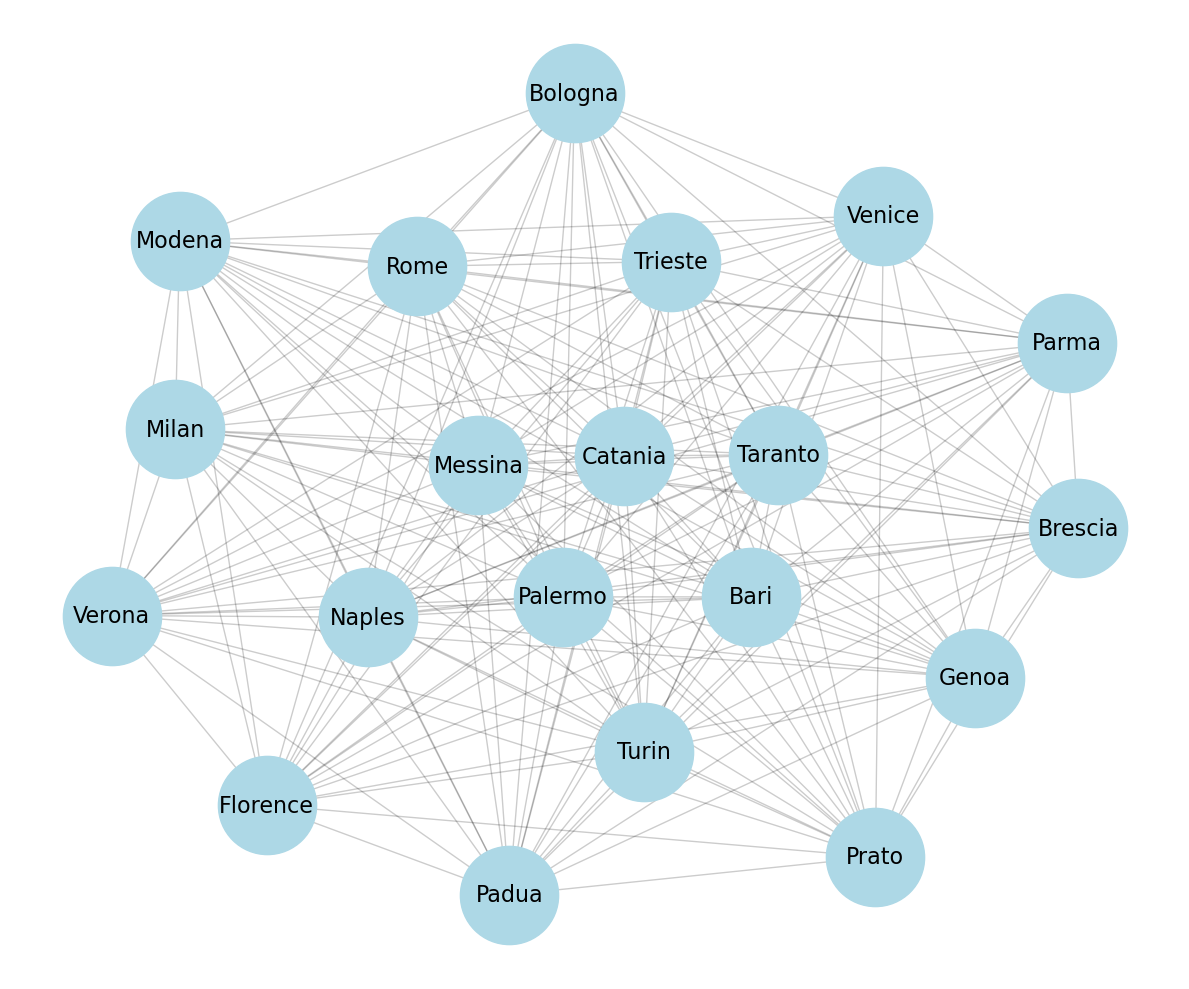

In [116]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load("problems/g_test.npy")
G = generate_graph(test_problem, labels=CITIES)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=2, seed=1)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=5000)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=16)
plt.axis("off")
plt.tight_layout()
plt.show()


### NetworkX's TSP Solver

We try NetworkX's built-in TSP solver first to have a baseline for comparison with our own implementation later. By default, it uses a Christofides approximation algorithm, which works only for metric TSPs (i.e., those that are symmetric and satisfy the triangle inequality).


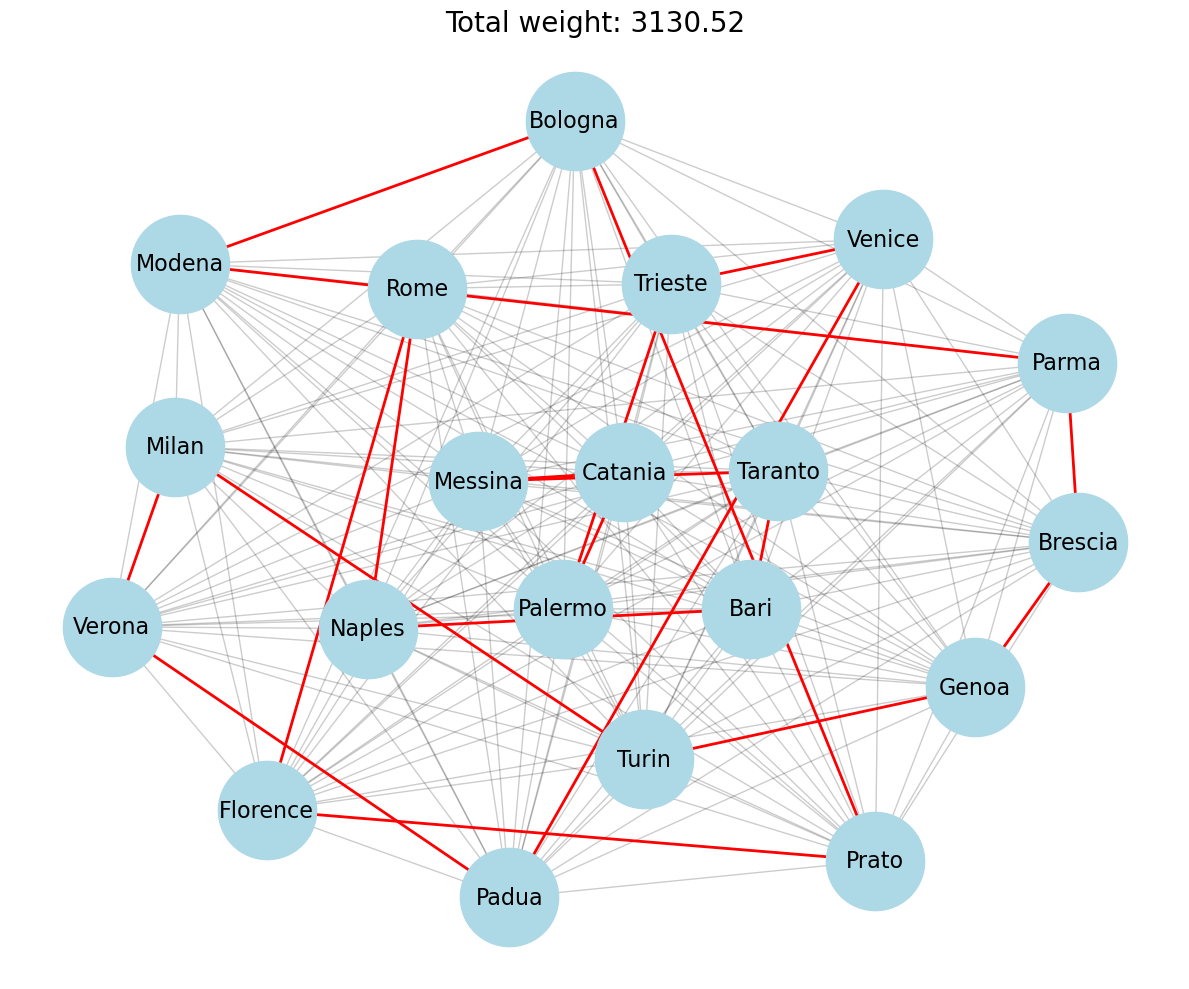

In [117]:
def plot_path(graph: nx.Graph | nx.DiGraph, path: list, weight: float):
    pos = nx.spring_layout(graph, k=2, seed=1)
    path_edges = list(zip(path, path[1:]))
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=5000)
    nx.draw_networkx_edges(graph, pos, alpha=0.2)
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color="r", width=2)
    nx.draw_networkx_labels(graph, pos, font_size=16)
    plt.title(f"Total weight: {weight:.2f}", fontsize=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


path = nx.approximation.traveling_salesman_problem(G, cycle=True)
weight = nx.path_weight(G, path, weight="weight")
plot_path(G, path, weight)

### Genetic Algorithm Approach

Next, we try to implement a genetic algorithm to solve the TSP. I chose swaps as the mutation operation and offered the option to choose between partially mapped crossover (PMX) or inver-over crossover (IOX) as the crossover operator. At each generation, only a subset of the best individuals are selected to breed the next generation. Tournament selection is used to select parents for crossover.

- I also tried to adjust mutation by using simulated annealing to start with a higher mutation rate that decreases over time but it did not yield better results.
- I also tried with a adaptive mutation rate that swaps multiple cities at once for longer paths, but that also did not yield better results.
- I also tried to inject random new individuals every 50 generations to maintain diversity, but that also did not yield better results.
- Finally, it seems that using both crossover methods together yields better results than using only one of them.


In [118]:
def fitness(path: list[int], graph: nx.Graph) -> float:
    return nx.path_weight(graph, path, weight="weight")


def swap_mutation(path: list[int]) -> None:
    """
    Swap in-place two cities in the path to create a mutation.

    Args:
        path (list[int]): The current path representing a TSP solution. (mut)
    """

    a, b = np.random.choice(len(path), size=2, replace=False)
    path[a], path[b] = path[b], path[a]

def inversion_mutation(path: list[int]) -> None:
    a, b = sorted(np.random.choice(len(path), size=2, replace=False))
    path[a:b] = reversed(path[a:b])

def pmx(parent1: list[int], parent2: list[int]) -> list[int]:
    """
    Partially Mapped Crossover (PMX) between two parents.

    The algorithm works as follows:
    1. Select two crossover points randomly that define a segment.
    2. Copy the a segment from parent1 to the child.
    3. For each position outside the segment, fill in genes from parent2, making
        sure that no duplicates occur in the child.

    Args:
        parent1 (list[int]): The first parent path.
        parent2 (list[int]): The second parent path.

    Returns:
        list[int]: The child path resulting from the crossover.
    """

    n = len(parent1)
    start, end = sorted(np.random.choice(range(n), size=2, replace=False))

    seg1 = parent1[start:end]
    seg2 = parent2[start:end]

    child = [-1] * n
    child[start:end] = seg1

    # iterate outside the copied segment
    for i in list(range(0, start)) + list(range(end, n)):
        gene = parent2[i]
        # iterate until we have a new gene in the child
        while gene in seg1:
            j = seg1.index(gene)
            gene = seg2[j]
        child[i] = gene

    return child


def iox(parent1: list[int], parent2: list[int]) -> list[int]:
    """
    Implements the Inver-over crossover operator.

    The algorithm works as follows:
    1. Select a random value from parent1.
    2. Find the position of this value in parent2.
    3. Find the position of the next value of parent2 from the first value in
        parent1.
    4. Reverse the segment in parent1 between these two positions in a circular
        manner such that the edge in parent2 is preserved and the ones in
        parent1 reversed.

    Args:
        parent1 (list[int]): The first parent path.
        parent2 (list[int]): The second parent path.

    Returns:
        list[int]: The child path resulting from the crossover.
    """

    start1 = np.random.randint(len(parent1))
    start2 = parent2.index(parent1[start1])

    next = parent2[(start2 + 1) % len(parent2)]
    end1 = parent1.index(next)

    child = parent1.copy()

    if start1 < end1:
        child[start1 + 1 : end1 + 1] = reversed(child[start1 + 1 : end1 + 1])
    else:
        # Wrap-around case: reverse segment from start1+1 wrapping to end1
        segment = child[start1 + 1 :] + child[: end1 + 1]
        segment.reverse()
        child[start1 + 1 :] = segment[: len(child) - start1 - 1]
        child[: end1 + 1] = segment[len(child) - start1 - 1 :]

    return child


CROSSOVER_FUNCTIONS = {"pmx": pmx, "iox": iox}


def tournament_selection(
    population: list[tuple[list[int], float]], tau: int = 5
) -> tuple[list[int], float]:
    """Select the best individual from a random subset of the population.

    Args:
        population (list[tuple[list[int], float]]): The population of
            individuals with their fitness values.
        tau (int): The number of individuals to select for the tournament.

    Returns:
        tuple[list[int], float]: The best individual from the tournament.
    """

    selected = np.random.choice(len(population), size=tau, replace=False)
    return min((population[i] for i in selected), key=lambda x: x[1])


def ga(
    graph: nx.Graph,
    population_size: int = 600,
    mutation_rate: float = 0.2,
    generations: int = 1000,
    elitism_rate: float = 0.2,
    crossover: Literal["pmx", "iox"] | None = None,
) -> tuple[list[int], float]:
    """Run a genetic algorithm to solve the TSP on the given graph.

    Args:
        graph (nx.Graph): The graph representing the TSP problem.
        population_size (int): The size of the population.
        mutation_rate (float): The probability of mutation for each child.
        generations (int): The number of generations to run the algorithm.
        elitism_rate (float): The proportion of the best individuals to carry
            over to the next generation.
        crossover (Literal["pmx", "iox"] | None): The crossover method to use.
            If None, a random method is chosen for each crossover.

    Returns:
        tuple[list[int], float]: The best path found and its fitness value.
    """

    nodes = list(graph.nodes)

    population = []
    for _ in range(population_size):
        path = np.random.permutation(nodes).tolist()
        fit = fitness(path, graph)
        bisect.insort(population, (path, fit), key=lambda x: x[1])

    pbar = tqdm(total=generations)
    for gen in range(generations):
        tau = 2 + 3 * (gen / (generations - 1))
        tau = int(round(tau))  

        new_population = population[: int(elitism_rate * population_size)]

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, tau)[0]
            parent2 = tournament_selection(population, tau)[0]

            choice = (
                crossover
                if crossover is not None
                else np.random.choice(list(CROSSOVER_FUNCTIONS.keys()))
            )
            child = CROSSOVER_FUNCTIONS[choice](parent1, parent2)

            if np.random.rand() < mutation_rate:
                inversion_mutation(child)

            fit = fitness(child, graph)
            bisect.insort(new_population, (child, fit), key=lambda x: x[1])

        population = new_population
        pbar.set_postfix({"Best fitness": f"{population[0][1]:.2f}"})
        pbar.update(1)

    return population[0]

# Problems

Run the genetic algorithm on all problems in the `problems` folder.


In [119]:

    problem = np.load(os.path.join("problems", "g_50.npy"))

    G = generate_graph(problem, directed=False, loop=False)

    best = ga(G)
    print(f"Best path for {filename}: {best[0]} with weight {best[1]:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Best path for r1_50.npy: [34, 10, 3, 11, 22, 43, 4, 2, 47, 46, 18, 20, 31, 19, 9, 29, 32, 42, 24, 37, 21, 33, 39, 26, 17, 8, 38, 49, 36, 41, 1, 12, 28, 15, 13, 35, 16, 23, 45, 44, 6, 7, 14, 25, 0, 27, 30, 5, 40, 48] with weight 2547.25
